# House Prices: Advanced Regression Techniques

### AI TF 머신러닝 과제

* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* Predict sales prices and practice feature engineering, RFs, and gradient boosting

### File descriptions

* **input/train.csv** 테스트 셋
* **input/test.csv** 트레인 셋
* **input/data_description.txt** 데이터 설명
* **input/sample_sumbission.csv** 정답 제출 샘플

### XGBRegressor 모델 사용
* ** Kagle Score : 0.13528 **
* Linear Regression 에서 사용한 feature 들만 사용 시 결과가 더 안 좋음
* 결측치가 많은 feature 들만 제외하고 나머지 모든 feature 사용
* feature 정리를 조금 더 정밀하게 하면 점수가 좋아질것 같음 
  - 수치형 categorical 데이터를 string 으로
  - 제외시킬 feature 추가 검토

In [135]:
import pandas as pd
import numpy as np

## Load Dataset

In [136]:
# train data
train = pd.read_csv("input/train.csv", index_col="Id")

print(train.shape)
train.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [137]:
# test data
test = pd.read_csv("input/test.csv", index_col="Id")

print(test.shape)
test.head()

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Preprocessing

#### linear regression 에서 feature 를 선택하는 방법
1. 데이터 탐색을 통해 SalePrice 와 선형 상관관계가 높고, 선형 regression 전제조건을 충족하는 feature 선택
2. 모든 feature 를 사용하고 Backward Elimination 을 통해 feature 를 줄여나가는 방법

#### sklearn linear regression 에서 feature scaling 이 필요한가?
1. linear regression 에서는 자동으로 feature scaling 되는것으로 알고 있음
   - SVN, K-Mean, Logistic Regression 처럼 feature scaling 이 필요한 모델들도 있음
   - from sklearn.preprocessing import StandardScaler 사용
2. lenear regression 에서 feature scaling 을 했을경우와 안했을경우 차이를 확인해 보자
   - 차이가 없음 : 자동으로 feature scaling 되고 있음

### outlier

1. outlier 데이터 제거 (GrLivArea, SalePrice 데이터 탐색 결과)

In [138]:
# 차트를 jupyter notebook에 출력해서 보기 위한 명령어
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

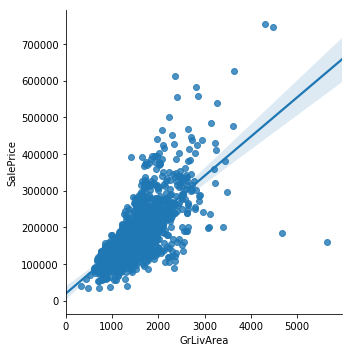

In [139]:
sns.lmplot(data=train, x="GrLivArea", y="SalePrice", fit_reg=True)

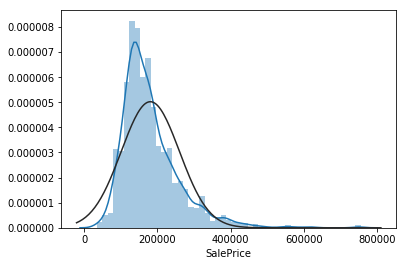

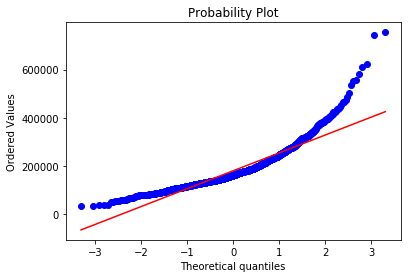

In [140]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [141]:
train = train.drop(
    train[(train['GrLivArea']>4000) & (train['SalePrice']<400000)].index)

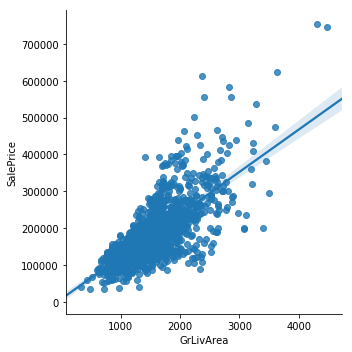

In [142]:
sns.lmplot(data=train, x="GrLivArea", y="SalePrice", fit_reg=True)

### One hot encoding

Categorical 데이터를 모두 one hot encoding 처리하기 위한 작업

numeric 데이터처럼 보이지만 categorical 데이터인 feature 들의 데이터타입을 string 으로 변환해서 one hot encoding이 되도록 함

In [143]:
# one-hot encoding 시 train/test 데이터의 feature 들이 가지고 있는 값들이 다르면 dummy column 갯수에 차이가 날 수 있음
# 하나로 합쳐놓고 전처리 한 다음에 다시 나누도록..
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print(all_data.shape)
all_data.head()

(2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [144]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2917 non-null int64
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 non

In [145]:
# Drop utilities column
all_data = all_data.drop(['Utilities'], axis=1)

In [146]:
# Impute missing categorical values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [147]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

#### Transform numerical to categorical

In [148]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallQual'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [149]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### One hot encoding

In [150]:
# train/predict 시 제외할 feature 지정`
# feature_drop = ['MasVnrArea','BsmtFinSF2','LowQualFinSF', 'LotFrontage','GarageYrBlt']
# all_data = all_data.drop(feature_drop, axis=1)

In [152]:
# Analyze data skewness
from scipy.stats import skew

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [153]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
all_data.loc[:, cols].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,3,2,4,5,5,2,4,0,3,2,...,0,3,2,1,1,1,10,4,2,4
2,5,2,4,5,5,3,4,0,3,3,...,0,3,2,1,1,1,5,7,1,7
3,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,11
4,2,4,1,5,5,3,4,2,3,2,...,0,0,2,1,1,1,11,4,0,4
5,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,3


In [154]:
# categorical 데이터를 one hot encoding
all_data_enc = pd.get_dummies(all_data)
print(all_data_enc.shape)
all_data_enc.head()

all_data_enc.to_csv('features.csv', index=False)

(2917, 228)


In [155]:
# train 시킬 데이터셋
X_train = all_data_enc[:train.shape[0]]

print(X_train.shape)
X_train.tail()

(1458, 228)


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1456,10,4.143135,8.976894,1,1,3,0,4,1999,2000,...,0,0,0,1,0,0,0,0,1,0
1457,5,4.454347,9.486152,1,1,3,0,5,1978,1988,...,0,0,0,1,0,0,0,0,1,0
1458,11,4.204693,9.109746,1,1,3,0,8,1941,2006,...,0,0,0,1,0,0,0,0,1,0
1459,5,4.234107,9.181735,1,1,3,0,5,1950,1996,...,0,0,0,1,0,0,0,0,1,0
1460,5,4.330733,9.204121,1,1,3,0,5,1965,1965,...,0,0,0,1,0,0,0,0,1,0


In [156]:
# test 데이터셋
X_test = all_data_enc[train.shape[0]:]

print(X_test.shape)
X_test.head()

(1459, 228)


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,5,4.394449,9.360741,1,1,3,0,5,1961,1961,...,0,0,0,1,0,0,0,0,1,0
1462,5,4.406719,9.565775,1,1,0,0,5,1958,1958,...,0,0,0,1,0,0,0,0,1,0
1463,10,4.317488,9.534668,1,1,0,0,4,1997,1998,...,0,0,0,1,0,0,0,0,1,0
1464,10,4.369448,9.208238,1,1,0,0,5,1998,1998,...,0,0,0,1,0,0,0,0,1,0
1465,0,3.784190,8.518392,1,1,0,0,4,1992,1992,...,0,0,0,1,0,0,0,0,1,0


### missing data in X_train

In [157]:
#missing data
total = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SaleCondition_Partial,0,0.0
Neighborhood_NAmes,0,0.0
Neighborhood_MeadowV,0,0.0
Neighborhood_IDOTRR,0,0.0
Neighborhood_Gilbert,0,0.0


### missing data in X_test

In [158]:
#missing data
total = X_test.isnull().sum().sort_values(ascending=False)
percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SaleCondition_Partial,0,0.0
Neighborhood_NAmes,0,0.0
Neighborhood_MeadowV,0,0.0
Neighborhood_IDOTRR,0,0.0
Neighborhood_Gilbert,0,0.0


In [159]:
# TotalBsmtSF null 값 확인
X_test[X_test['TotalBsmtSF'].isnull()]

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,


In [160]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test["TotalBsmtSF"]=imp.fit_transform(X_test[["TotalBsmtSF"]]).ravel()

# total_bsmtsf_mean = X_test['TotalBsmtSF'].mean()
# X_test.loc[X_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = total_bsmtsf_mean

C:\AI\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [161]:
# GarageCars null 값 확인
X_test[X_test['GarageCars'].isnull()]

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,


In [162]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test["GarageCars"]=imp.fit_transform(X_test[["GarageCars"]]).ravel()

# garagecars_mean = X_test['GarageCars'].mean()
# X_test.loc[X_test['GarageCars'].isnull(), 'GarageCars'] = garagecars_mean

C:\AI\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### model 

In [163]:
# train 시킬 때 사용할 label(target, 종속변수) 컬럼 선택
label_name = "SalePrice"

# train 시킬 때 사용할 label(target, 종속변수) 데이터셋 준비
y_train = np.log(train[label_name])

print(y_train.shape)
y_train.head()

(1458,)


Id
1    12.247694
2    12.109011
3    12.317167
4    11.849398
5    12.429216
Name: SalePrice, dtype: float64

In [177]:
import xgboost as xgb
# model = XGBRegressor(n_estimators=100,
#                      max_depth=10,
#                      seed=37,
#                      learning_rate=0.06);

model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             seed=37, nthread = -1);
model

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4603,
       gamma=0.0468, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=37, silent=1,
       subsample=0.5213)

### Scoring

Kaggle 에서 log 함수로 변환된 SalePrice 값을 RMSE 방식으로 scoring 하기 때문에 RMSE 함수 구현하여 사용

In [178]:
# RMSE 함수 구현
import numpy as np
from sklearn.metrics import make_scorer

def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
  
    difference = predict - actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmse_scorer = make_scorer(rmse)
rmse_scorer

make_scorer(rmse)

In [179]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(model, X_train, y_train, cv=10, \
                         scoring=rmse_scorer).mean()

print("Score = {0:.5f}".format(score))

Score = 0.11658


## Hyperparameter Tuning
https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

In [187]:
!pip install bayesian-optimization

Exception:
Traceback (most recent call last):
  File "C:\AI\Anaconda3\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "C:\AI\Anaconda3\lib\site-packages\pip\commands\install.py", line 335, in run
    wb.build(autobuilding=True)
  File "C:\AI\Anaconda3\lib\site-packages\pip\wheel.py", line 749, in build
    self.requirement_set.prepare_files(self.finder)
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_set.py", line 380, in prepare_files
    ignore_dependencies=self.ignore_dependencies))
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_set.py", line 554, in _prepare_file
    require_hashes
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_install.py", line 278, in populate_link
    self.link = finder.find_requirement(self, upgrade)
  File "C:\AI\Anaconda3\lib\site-packages\pip\index.py", line 465, in find_requirement
    all_candidates = self.find_all_candidates(req.name)
  File "C:\AI\Anaconda3\lib\site-packages\pip\ind

In [ ]:
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 300
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=5, high=20)
    learning_rate = np.random.uniform(low=0.01, high=0.1)

    model = XGBRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  seed=37)

    score = cross_val_score(model, X_train, y_train, cv=10, \
                            scoring=rmse_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
    })

    print("Learning Rate = {0: .3f} Score = {1:.5f}".format(learning_rate, score))
 
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

## Train

In [180]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4603,
       gamma=0.0468, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=37, silent=1,
       subsample=0.5213)

## Predict

In [181]:
# RMSE scoreing 하기 위해 log로 변환했던 값을 다시 원복해야 함
predictions = np.exp(model.predict(X_test))
print(predictions.shape)
predictions

(1459,)


array([ 123444.9765625,  161006.28125  ,  199554.59375  , ...,
        157260.828125 ,  123703.421875 ,  222338.3125   ], dtype=float32)

## Submit (kaggle 제출용)

In [182]:
submission = pd.read_csv("input/sample_submission.csv", index_col="Id")

submission["SalePrice"] = predictions

print(submission.shape)
submission.head()

(1459, 1)


,SalePrice
Id,
1461,123444.976562
1462,161006.281250
1463,199554.593750
1464,201744.046875
1465,178591.515625


In [183]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "xgb-regressor"

filename = "{date}_{desc}_{score}.csv".format(date=current_date, desc=description, score="{0:.5f}".format(score))
filepath = "output/{filename}".format(filename=filename)

submission.to_csv(filepath)

In [189]:
! pip install scikit-optimize

Exception:
Traceback (most recent call last):
  File "C:\AI\Anaconda3\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "C:\AI\Anaconda3\lib\site-packages\pip\commands\install.py", line 335, in run
    wb.build(autobuilding=True)
  File "C:\AI\Anaconda3\lib\site-packages\pip\wheel.py", line 749, in build
    self.requirement_set.prepare_files(self.finder)
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_set.py", line 380, in prepare_files
    ignore_dependencies=self.ignore_dependencies))
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_set.py", line 554, in _prepare_file
    require_hashes
  File "C:\AI\Anaconda3\lib\site-packages\pip\req\req_install.py", line 278, in populate_link
    self.link = finder.find_requirement(self, upgrade)
  File "C:\AI\Anaconda3\lib\site-packages\pip\index.py", line 465, in find_requirement
    all_candidates = self.find_all_candidates(req.name)
  File "C:\AI\Anaconda3\lib\site-packages\pip\ind